In [0]:
import org.apache.spark

In [0]:
!pip install wordcloud

     |████████████████████████████████| 371 kB 5.4 MB/s 
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
from pyspark.sql import SparkSession
import pandas as pd
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_set, col, count
from pyspark.ml.fpm import FPGrowth

In [0]:
orders = spark.read.csv("/FileStore/tables/orders.csv", header="true", inferSchema="true")

In [0]:
order_products_prior = spark.read.csv("/FileStore/tables/order_products__prior.csv", header="true", inferSchema="true")

In [0]:
urlA = 'https://drive.google.com/file/d/1W8bNivEj7H0WXqZx1X83fQEYz4A3XadY/view?usp=sharing'
urlA2 = 'https://drive.google.com/uc?id=' + urlA.split('/')[-2]
aislesPD = pd.read_csv(urlA2)
aisles = spark.createDataFrame(aislesPD)

In [0]:
urlD = 'https://drive.google.com/file/d/1unatDL4jGx5CCHYN2Q9YnDjnq43AgtJp/view?usp=sharing'
urlD2 = 'https://drive.google.com/uc?id=' + urlD.split('/')[-2]
departmentsPD = pd.read_csv(urlD2)
departments = spark.createDataFrame(departmentsPD)


In [0]:
urlOPT = 'https://drive.google.com/file/d/1IyZbHlrD8zXB8zhgx2XKxt812THThGRu/view?usp=sharing'
urlOPT2 = 'https://drive.google.com/uc?id=' + urlOPT.split('/')[-2]
order_products_trainPD = pd.read_csv(urlOPT2)
order_products_train = spark.createDataFrame(order_products_trainPD)

In [0]:
urlP = 'https://drive.google.com/file/d/1Gkwkg56XgLzX_hyZDjEyHyRbcSjuWKp3/view?usp=sharing'
urlP2 = 'https://drive.google.com/uc?id=' + urlP.split('/')[-2]
productsPD = pd.read_csv(urlP2)
products = spark.createDataFrame(productsPD)

In [0]:
#putting dataframes in database
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

In [0]:
df = sqlContext.sql("select count(order_id) as total_orders, order_hour_of_day as hour from orders group by order_hour_of_day order by order_hour_of_day")
df.show()

+------------+----+
|total_orders|hour|
+------------+----+
|       22758|   0|
|       12398|   1|
|        7539|   2|
|        5474|   3|
|        5527|   4|
|        9569|   5|
|       30529|   6|
|       91868|   7|
|      178201|   8|
|      257812|   9|
|      288418|  10|
|      284728|  11|
|      272841|  12|
|      277999|  13|
|      283042|  14|
|      283639|  15|
|      272553|  16|
|      228795|  17|
|      182912|  18|
|      140569|  19|
+------------+----+
only showing top 20 rows



In [0]:
%sql
select count(order_id) as total_orders, order_hour_of_day as hour 
from orders 
group by order_hour_of_day 
order by order_hour_of_day

total_orders,hour
22758,0
12398,1
7539,2
5474,3
5527,4
9569,5
30529,6
91868,7
178201,8
257812,9


In [0]:
%sql
select days_since_prior_order, count(order_id) as total_orders
from orders 
group by days_since_prior_order 
order by days_since_prior_order

days_since_prior_order,total_orders
null,206209
0.0,67755
1.0,145247
2.0,193206
3.0,217005
4.0,221696
5.0,214503
6.0,240013
7.0,320608
8.0,181717


In [0]:
%sql
select count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from orders  
 group by order_dow 
 order by total_orders desc

total_orders,day_of_week
600905,Sunday
587478,Monday
467260,Tuesday
453368,Friday
448761,Saturday
436972,Wednesday
426339,Thursday


In [0]:
%fs rm -r dbfs:/user/hive/warehouse/data

res0: Boolean = true

In [0]:
%sql
create table data as (select op.*, p.product_name, p.aisle_id, p.department_id, d.department from (select * from order_products_train union 
select * from order_products_prior) as op inner join products as p on op.product_id = p.product_id inner join departments as d on p.department_id = d.department_id)

num_affected_rows,num_inserted_rows


In [0]:
%sql
select order_id,count(product_id) as number_of_items
from data
group by order_id

order_id,number_of_items
2214,18
2250,17
4590,10
6721,12
9715,18
13638,10
15322,8
15371,9
15437,11
15663,9


In [0]:
%sql
select product_name, count(*) as orders_count from data
group by product_name
order by orders_count desc
limit 10

product_name,orders_count
Banana,491291
Bag of Organic Bananas,394930
Organic Strawberries,275577
Organic Baby Spinach,251705
Organic Hass Avocado,220877
Organic Avocado,184224
Large Lemon,160792
Strawberries,149445
Limes,146660
Organic Whole Milk,142813


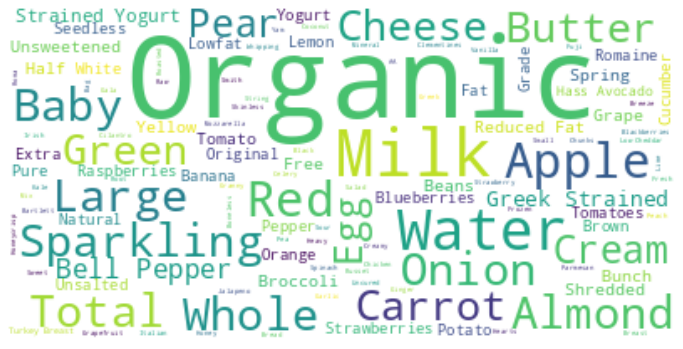

In [0]:
#fetching data from database to dataset
data = sqlContext.sql("SELECT product_name FROM (select product_name, count(*) as orders_count from data group by product_name order by orders_count desc limit 200)")
#converting to RDD
dataRDD = data.rdd.flatMap(lambda x: x).collect()
strs = ' '.join(dataRDD)
#plot a wordcloud diagram
wc = WordCloud(background_color="white").generate(strs)
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
display()

In [0]:
sparkData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
#get baskets
bskts = sparkData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
bskts.createOrReplaceTempView('baskets')
print()
sparkData.show(5)
bskts.show(5)


+--------------------+--------+
|        product_name|order_id|
+--------------------+--------+
|    Bulgarian Yogurt|       1|
|Organic 4% Milk F...|       1|
|Organic Celery He...|       1|
|      Cucumber Kirby|       1|
|Lightly Smoked Sa...|       1|
+--------------------+--------+
only showing top 5 rows

+--------+--------------------+
|order_id|               items|
+--------+--------------------+
|     112|[Umcka Elderberry...|
|     844|[Organic Shredded...|
|    1042|[Pure Irish Butte...|
|    1077|[Sparkling Water,...|
|    1119|[Broccoli Crown, ...|
+--------+--------------------+
only showing top 5 rows



In [0]:
print('The baskets of orders are displayed below.')
display(bskts)

The baskets of orders are displayed below.


order_id,items
112,"List(Umcka Elderberry Intensive Cold + Flu Berry Flavor, Fresh Cauliflower, I Heart Baby Kale, Hickory Honey Barbeque Baked Potato Chips, Sea Salt Baked Potato Chips, Premium Epsom Salt, Baked Sea Salt & Vinegar Potato Chips, Organic Hass Avocado, Organic Lemon, Marinara Pasta Sauce, Coconut Water Kefir)"
844,"List(Organic Red Radish, Bunch, Baby Spinach, Organic Shredded Carrots, Granny Smith Apples, Green Beans, Cheese Pizza Snacks, Garlic Couscous)"
1042,"List(Pure Irish Butter, Organic Oat Cakes, Organic Lentil Soup, Applewood Smoked Bacon, Banana, Organic Large Brown Eggs, Organic Whole Cashews, Michigan Organic Kale)"
1077,"List(Sparkling Water, Organic Strawberries, Celery Sticks, Bag of Organic Bananas)"
1119,"List(Shallot, Large Lemon, Fresh Cauliflower, Boneless Skinless Chicken Breast, Organic Grade A Free Range Large Brown Eggs, Broccoli Crown)"
1145,"List(Mexican Casserole Bowl, Light Mozzarella String Cheese, 2% Low Fat Cottage Cheese, Instant Whole Grain Brown Rice, Classic Stir-fry Sauce, Nacho Cheese & Bean Snacks, Everything Bagel, Spaghetti Pasta, Banana, Original Red Raspberry Yogurt, Milano Milk Chocolate Cookies, Natural Uncured Turkey Hot Dog, Stir Fry Seasoning Mix, Shredded Mild Cheddar Cheese, Little Bites Blueberry Muffin Pouches, Strawberries, Danimals Strawberry Explosion & Strikin' Strawberry Kiwi Smoothies, Spinach Pizza, Roma Tomato, Hash Brown Potato Patties, Harvest Cheddar Multigrain Chips, Harvest Best in 100% Fruit Juice Mandarin Oranges, Original French Toast Sticks, Multi Grain Cheerios Cereal, Signature Recipes Vodka Sauce Pasta Sauce, Eggs, Cheese & Turkey Sausage Breakfast Burrito, Healthy Multi Grain Bread, Goldfish Parmesan Baked Snack Crackers, Strawberry Frozen Greek Yogurt Bars, Original Nooks & Crannies English Muffins)"
1280,"List(Vanilla Soy Milk, French Vanilla Creamer, Organic Half & Half, Lactose Free Half & Half, Organic Whole Milk)"
1571,"List(Clementines, Bag, Organic Banana, All Natural Homestyle California Lemon Limeade, Natural Artisan Water)"
1591,"List(Cracked Wheat, Strawberry Rhubarb Yoghurt, Organic Bunny Fruit Snacks Berry Patch, Goodness Grapeness Organic Juice Drink, Honey Graham Snacks, Spinach, Granny Smith Apples, Oven Roasted Turkey Breast, Pure Vanilla Extract, Chewy 25% Low Sugar Chocolate Chip Granola, Banana, Original Turkey Burgers Smoke Flavor Added, Twisted Tropical Tango Organic Juice Drink, Navel Oranges, Lower Sugar Instant Oatmeal Variety, Ultra Thin Sliced Provolone Cheese, Natural Vanilla Ice Cream, Cinnamon Multigrain Cereal, Garlic, Goldfish Pretzel Baked Snack Crackers, Original Whole Grain Chips, Medium Scarlet Raspberries, Lemon Yogurt, Original Patties (100965) 12 Oz Breakfast, Nutty Bars, Strawberry Banana Smoothie, Green Machine Juice Smoothie, Coconut Dreams Cookies, Buttermilk Waffles, Uncured Genoa Salami, Organic Greek Whole Milk Blended Vanilla Bean Yogurt)"
1983,"List(Honey Nut Cheerios, Organic Gala Apple, Organic Honey Sweet Whole Wheat Bread, Everything Bagels, Dark Sweet Cherries, Strawberry Rhubarb Yogurt, Organic Garbanzo Beans, 100% Whole Wheat Bread, Almond Butter Minis Bar, Raw Cashew Nut Butter, Organic Original Hommus, Plain Bagels, Organic Fat Free Milk, Organic Strawberries, Muffins, Flax, Wild Blueberry, Rocky Mountain Sourdough Bread, Roasted Turkey Breast, No Salt Added Black Beans, Organic Banana, Ice Cream Chocolate Mocha Chip, Cookie Dough Ice Cream Chocolate Chip, Mexican Chocolate Yogurt, Organic Roasted Turkey Breast, Broccoli Crown, S'mores Ice Cream, Cream Cheese Spread, Thick & Chunky Salsa, Organic Baby Carrots, Peanut Butter Ice Cream Cup)"


In [0]:
#traing Frequent pattern mining model
fpg = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)
fpModel = fpg.fit(bskts)
#The frequently bought items are:
fpModel.freqItemsets.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Extra Ginger Bre...| 259|
|[Whole Strawberries]| 365|
|      [Organic Lime]| 140|
|  [Chopped Tomatoes]| 159|
|[Low Fat Plain Yo...| 200|
|[Organic Tomato B...| 772|
|[Organic Tomato B...| 175|
|[Organic Tomato B...| 144|
|[Organic Tomato B...| 179|
|[Thin & Light Tor...| 301|
|           [Ice Bag]| 135|
|   [Bunched Carrots]| 167|
|[Kids Organic Cho...| 451|
|[Scoops! Tortilla...| 398|
|[Natural Free & C...| 277|
|[Organic Large Br...|1137|
|[Organic Large Br...| 201|
|[Organic Large Br...| 280|
|[Organic Large Br...| 138|
|[Organic Large Br...| 145|
+--------------------+----+
only showing top 20 rows



In [0]:
#The associated rules are:
fpModel.associationRules.show()

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|[Trilogy Kombucha...|[Bag of Organic B...|0.21739130434782608|1.8426159982024493|0.001066999977135...|
|[Organic Shredded...|[Organic Strawber...|  0.163855421686747|1.9734997268309513|0.001036514263503...|
|[Organic Shredded...|[Bag of Organic B...| 0.1891566265060241|1.6032979203636253|0.001196564260073623|
|[Organic Shredded...|[Organic Baby Spi...|0.24819277108433735| 3.328406101921997|0.001570014252071123|
|[Organic Shredded...|            [Banana]|0.22409638554216868| 1.570194523689117|0.001417585683908...|
| [Green Bell Pepper]|[Orange Bell Pepper]|0.10035700119000397|7.0642391465339225|0.001928221387252399|
| [Green Bell Pepper]|[Organic Red Bell...|0.10234034113447045| 

In [0]:
#The associated items are:
fpModel.transform(bskts).show()

+--------+--------------------+--------------------+
|order_id|               items|          prediction|
+--------+--------------------+--------------------+
|     112|[Umcka Elderberry...|[Organic Raspberr...|
|     844|[Organic Shredded...|[Organic Strawber...|
|    1042|[Pure Irish Butte...|[Organic Strawber...|
|    1077|[Sparkling Water,...|[Organic Large Br...|
|    1119|[Broccoli Crown, ...|[Organic Large Ex...|
|    1145|[Light Mozzarella...|[Organic Strawber...|
|    1280|[Vanilla Soy Milk...|[Organic Large Ex...|
|    1571|[Clementines, Bag...|[Organic Strawber...|
|    1591|[Honey Graham Sna...|[Blueberry Yoghur...|
|    1983|[Honey Nut Cheeri...|[Banana, Organic ...|
|    2021|[Organic Yellow O...|[Organic Large Ex...|
|    2530|[Total 2% with St...|[Total 2% Lowfat ...|
|    3091|[Lemon Ginger Tea...|[Organic Tomato B...|
|    3200|[Pineapple Spears...|[Packaged Grape T...|
|    3243|[Vanilla Almond M...|[Organic Strawber...|
|    3327|[Coconut Flakes, ...|[Organic Large 